# Constants

In [2]:
model_archietcture = "matrix_cadec"

dataset_dir = f"./datasets/cadec"
model_path = f"./models/{model_archietcture}.pth"

# Utility

In [7]:
from transformers import AutoTokenizer

def compute_pos_weights(loader, tokenizer, device="cpu"):
    upper_ones = 0
    upper_zeros = 0
    lower_ones = 0
    lower_zeros = 0
    total_sentences = 0

    for batch in loader:
        tokens, target_matrix_batch, _ = batch
        input_ids = tokens["input_ids"].to(device)
        target_matrix_batch = target_matrix_batch.to(device)

        # Get word_ids for each batch sample
        word_ids_batch = [tokens.word_ids(batch_index=i) for i in range(len(input_ids))]

        for i, matrix in enumerate(target_matrix_batch):
            word_ids = word_ids_batch[i]
            max_word_id = max([wid for wid in word_ids if wid is not None], default=-1)
            valid_len = max_word_id + 1  # True number of words in original sentence

            if valid_len == 0:
                continue  # skip if no valid words

            matrix = matrix[:valid_len, :valid_len]

            upper = torch.triu(matrix, diagonal=0)
            lower = torch.tril(matrix, diagonal=-1)

            upper_ones += (upper == 1).sum().item()
            upper_zeros += (upper == 0).sum().item()

            lower_ones += (lower == 1).sum().item()
            lower_zeros += (lower == 0).sum().item()

            total_sentences += 1

    print(f"Stats over {total_sentences} valid samples:")
    print(f"Upper Triangle: 1s={upper_ones}, 0s={upper_zeros}")
    print(f"Lower Triangle: 1s={lower_ones}, 0s={lower_zeros}")

    if upper_ones > 0:
        upper_pos_weight = upper_zeros / upper_ones
        print(f"Suggested upper pos_weight: {upper_pos_weight:.2f}")
    else:
        upper_pos_weight = None
        print("No 1s in upper triangle")

    if lower_ones > 0:
        lower_pos_weight = lower_zeros / lower_ones
        print(f"Suggested lower pos_weight: {lower_pos_weight:.2f}")
    else:
        lower_pos_weight = None
        print("No 1s in lower triangle")

    return upper_pos_weight, lower_pos_weight

train_loader = get_train_loader()
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased", use_fast=True)
upper_w, lower_w = compute_pos_weights(train_loader, tokenizer, torch.device("cuda" if torch.cuda.is_available() else "cpu"),)

Stats over 615 valid samples:
Upper Triangle: 1s=5055, 0s=3594966
Lower Triangle: 1s=1988, 0s=3598033
Suggested upper pos_weight: 711.17
Suggested lower pos_weight: 1809.88


In [1]:
import os

def delete_folder(folder_path):
    if os.path.exists(folder_path):
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            if os.path.isfile(file_path):
                os.remove(file_path)  # Delete file
            elif os.path.isdir(file_path):
                delete_folder(file_path)  # Recursively delete subfolder
        os.rmdir(folder_path)  # Finally, remove the now-empty folder
        print(f"Deleted folder: {folder_path}")
    else:
        print("Folder does not exist.")


# Dataset

## Cadec

In [54]:
import os
import json
import numpy as np
from datasets import load_from_disk, DatasetDict

# Load the newly saved CADEC dataset
dataset_dir = "./datasets/cadec_original"
dataset = load_from_disk(dataset_dir)

# Define the output directory
output_dir = "./datasets/cadec"
os.makedirs(output_dir, exist_ok=True)

# Split dataset (70% Train, 15% Test, 15% Validation)
dataset = dataset["train"].train_test_split(test_size=0.3, seed=42)
test_valid = dataset["test"].train_test_split(test_size=0.5, seed=42)  # Split 50/50 between test & validation

# Create final splits
split_datasets = {
    "train": dataset["train"],  # 70%
    "test": test_valid["train"],  # 15%
    "validation": test_valid["test"]  # 15%
}

def save_matrices(dataset_split, split_name):
    """
    Save entity matrices in the required format without modification.
    """
    split_dir = os.path.join(output_dir, split_name)
    os.makedirs(split_dir, exist_ok=True)

    for idx, example in enumerate(dataset_split):
        words = example["text"].split()  # Tokenized words
        entities = example["ade"]  # The ADEs are already provided
        entity_matrix = np.array(example["entity_matrix"])  # Convert back to 2D array

        # Save the entry
        entry = {
            "words": words,
            "entity_matrix": entity_matrix.tolist(),  # Ensure JSON compatibility
            "entities": entities  # Keep original spans
        }

        # Save as a JSON file
        file_path = os.path.join(split_dir, f"sentence_{idx}.json")
        with open(file_path, "w") as f:
            json.dump(entry, f)

# Save matrices for train, test, and validation splits
for split_name, split_data in split_datasets.items():
    save_matrices(split_data, split_name)

print(f"Formatted CADEC dataset saved to {output_dir} with 70/15/15 split.")


Formatted CADEC dataset saved to ./datasets/cadec with 70/15/15 split.


# Model

## Dataloader and Collate Function

In [3]:
from torch.utils.data import Dataset
import torch
import os
import json

class EntityMatrixDataset(Dataset):
    def __init__(self, data_dir, tokenizer, max_seq_length=128):
        """
        Initialize the dataset by loading all JSON files from the directory.
        
        Args:
            data_dir: Path to the directory containing JSON files.
            tokenizer: Tokenizer to encode tokens.
            max_seq_length: Maximum sequence length for padding/truncation.
        """
        self.data = []
        self.tokenizer = tokenizer
        self.max_seq_length = max_seq_length

        for file_name in os.listdir(data_dir):
            if file_name.endswith(".json"):
                with open(os.path.join(data_dir, file_name), "r") as f:
                    entry = json.load(f)
                    
                    # **Extract only the single-word entity labels**
                    entry["entity_matrix"] = entry["entity_matrix"]  

                    self.data.append(entry)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """
        Get the words and single-word entity vector for the given index.
        
        Returns:
            - words: List of words in the sentence.
            - single_word_labels: Tensor with 1s for single-word entities, 0s otherwise.
        """
        entry = self.data[idx]
        words = entry["words"]  # List of words
        entities = entry["entities"]
        entity_matrix = torch.tensor(entry["entity_matrix"], dtype=torch.float32)
        return words, entity_matrix, entities


In [4]:
from torch.utils.data import DataLoader, Dataset
import torch

def collate_fn(batch, tokenizer, max_seq_length=128):
    """
    Collate function to pad words and entity matrices within a batch.

    Args:
        batch: List of tuples (words, entity_matrix).
        tokenizer: Tokenizer to encode and pad words.
        max_seq_length: Maximum sequence length for padding.

    Returns:
        - Encoded tokenized inputs (input_ids, attention_mask, word_ids).
        - Padded entity matrices tensor.
    """
    # Unpack tuples
    words_batch, matrices_batch, entities = zip(*batch)

    # Tokenize and pad words
    encoded = tokenizer(
        list(words_batch),
        is_split_into_words=True,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=max_seq_length
    )

    # Determine batch size and padded sequence length
    batch_size = len(batch)
    padded_seq_len = max_seq_length

    # Initialize a zero-padded entity matrix (batch_size, max_seq_length, max_seq_length)
    padded_matrices = torch.zeros((batch_size, padded_seq_len, padded_seq_len), dtype=torch.float32)

    for i, (matrix, words) in enumerate(zip(matrices_batch, words_batch)):
        size = len(words)
        matrix = matrix.reshape((size, size))
        seq_len = min(matrix.shape[0], padded_seq_len)  # Ensure we don't exceed max size
        padded_matrices[i, :seq_len, :seq_len] = matrix[:seq_len, :seq_len]
        
    return encoded, padded_matrices, entities

### Collate Debug

In [8]:
from torch.utils.data import DataLoader
from transformers import AutoTokenizer

# Initialize dataset
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased", use_fast=True)
dataset = EntityMatrixDataset(f"{dataset_dir}/train", tokenizer)

# Create DataLoader with collate function
dataloader = DataLoader(
    dataset,
    batch_size=8,
    shuffle=True,
    collate_fn=lambda batch: collate_fn(batch, tokenizer)
)

# Fetch a batch and print debug info
for batch in dataloader:
    encoded_inputs, padded_labels, entities = batch

    print(encoded_inputs[0])
    print(padded_labels[0][:15,:15])
    print(entities)

    break  # Only print first batch


Encoding(num_tokens=128, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.,

## Model

In [5]:
import torch
import torch.nn as nn
from transformers import BertModel

class EntityMatrixPredictor(nn.Module):
    def __init__(self, bert_model_name="bert-base-cased", hidden_dim=768, num_heads=4, dropout=0.1):
        super(EntityMatrixPredictor, self).__init__()

        self.hidden_dim = hidden_dim
        self.bert = BertModel.from_pretrained(bert_model_name)

        # MLP to process word embeddings before span classification
        self.mlp_forward = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), 
            nn.ReLU()
        )

        # Learnable vector for dot product projection
        self.v_forward = nn.Parameter(torch.randn(hidden_dim))  # (hidden_dim,)

        # MLP to process word embeddings before span classification
        self.mlp_backward = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), 
            nn.ReLU()
        )

        # Learnable vector for dot product projection
        self.v_backward = nn.Parameter(torch.randn(hidden_dim))  # (hidden_dim,)

    def forward(self, input_ids, attention_mask, word_ids):
        batch_size, _ = input_ids.shape

        # Step 1: Get BERT Token Embeddings
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        token_embeddings = bert_output.last_hidden_state  # (batch, seq_len, hidden_dim)

        # Step 2: Aggregate Token Embeddings into Word Embeddings
        max_words = max([max([wid for wid in word_id if wid is not None], default=-1) + 1 for word_id in word_ids])
        word_embeddings = torch.zeros((batch_size, max_words, token_embeddings.shape[-1]), device=token_embeddings.device)

        for i in range(batch_size):
            word_counts = torch.zeros((max_words, 1), device=token_embeddings.device)
            for token_idx, word_idx in enumerate(word_ids[i]):
                if word_idx is not None:
                    word_embeddings[i, word_idx] += token_embeddings[i, token_idx]
                    word_counts[word_idx] += 1

            word_embeddings[i] /= word_counts.clamp(min=1)  # Avoid division by zero

        # Step 4: Construct Word Pair Matrix (Concatenation of i-th and j-th word)
        i_emb = word_embeddings.unsqueeze(2).expand(-1, -1, max_words, -1)  # (batch, max_words, max_words, hidden_dim)
        j_emb = word_embeddings.unsqueeze(1).expand(-1, max_words, -1, -1)  # (batch, max_words, max_words, hidden_dim)
        pair_matrix = torch.cat((i_emb, j_emb), dim=-1)  # (batch, max_words, max_words, hidden_dim * 2)

        logits_forward = torch.triu(torch.matmul(self.mlp_forward(pair_matrix), self.v_forward))  # (batch, max_words, max_words)
        logits_backward = torch.tril(torch.matmul(self.mlp_backward(pair_matrix), self.v_backward), diagonal=-1)  # (batch, max_words, max_words)

        return logits_forward + logits_backward  # Raw logits (can be passed to BCEWithLogitsLoss)


## Loss

# Training

## Train Subset Loader

In [6]:
from torch.utils.data import DataLoader
from torch.utils.data import Subset

from transformers import AutoTokenizer

def get_train_loader(dataset_dir=dataset_dir, subset_size = None):
    # Ensure you are using a Fast Tokenizer
    tokenizer = AutoTokenizer.from_pretrained("bert-base-cased", use_fast=True)

    # Load dataset
    train_dir = f"{dataset_dir}/train"  # Path to your dataset
    train_dataset = EntityMatrixDataset(train_dir, tokenizer)

    if subset_size is not None:
        train_dataset = Subset(train_dataset, list(range(subset_size)))
    
    # Use the subset in the DataLoader
    train_loader = DataLoader(
        train_dataset,
        batch_size=32,
        shuffle=True,
        collate_fn=lambda batch: collate_fn(batch, tokenizer)
    )

    return train_loader

In [9]:
import torch
import torch.nn as nn

def training_loop(
        model = EntityMatrixPredictor(),
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu"), 
        epochs = 3, 
        pos_weight = 15, 
        verbose = False, 
        subset_size = None):

    model.to(device)
    loss_bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight], device=device))

    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
    
    for epoch in range(epochs):
        model.train()

        total_loss = 0
        train_loader = get_train_loader(subset_size = subset_size)

        for batch in train_loader:
            tokens = batch[0]
            target_matrix = batch[1].to(device)  # Ensure targets are on the correct device

            input_ids = tokens["input_ids"].to(device)
            attention_mask = tokens["attention_mask"].to(device)

            # Extract `word_ids` only once for the batch
            word_ids = [tokens.word_ids(batch_index=i) for i in range(len(input_ids))]
            
            optimizer.zero_grad()

            # Forward pass (now includes word_ids)
            predicted_matrix = model(input_ids=input_ids, attention_mask=attention_mask, word_ids=word_ids)

            # **Mask the target matrix to match valid words in predicted matrix**
            _, max_words, _ = predicted_matrix.shape
            target_matrix = target_matrix[:, :max_words, :max_words]  # Trim to match predicted size

            # Compute loss directly over the valid portion
            loss = loss_bce(predicted_matrix, target_matrix)
            loss.backward()
            optimizer.step()
            if verbose: print(f"Batch loss {loss.item()}")
            total_loss += loss.item()

        # Compute average loss for epoch
        epoch_loss = total_loss / len(train_loader)
        if verbose: print(f"Epoch {epoch+1}, Loss: {epoch_loss}")

    return model

In [ ]:
model = training_loop(verbose=True)
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to ./models/matrix_cadec.pth


# Evaluation

In [10]:
def extract_spans_from_matrix(matrix):
    """
    Extracts and merges entity spans by collapsing linked words in the **upper triangular** part of the entity matrix.

    Args:
        matrix (torch.Tensor): Binary entity matrix (size: max_words x max_words).

    Returns:
        merged_spans (set of tuples): Extracted entity spans in (start, end) format.
    """
    max_words = matrix.shape[0]
    spans = []

    # **Step 1: Extract Raw Spans from Upper Triangle**
    for i in range(max_words):
        if matrix[i, i] == 1:
                spans.append([i, i])

    start = -1
    for i in range(max_words-1):
        if matrix[i,i+1] == 1:
            if start == -1:
                start = i
        elif start != -1:
            spans.append([start,i])
            start = -1
    if start != -1:
         spans.append([start,max_words-1])

    return spans  # Convert to set for unique values


In [11]:
import torch
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import precision_score, recall_score, f1_score
from transformers import AutoTokenizer

def evaluation_loop_sharp(model_path):
    """
    Evaluates the model using extracted spans for precision, recall, and F1-score.

    Args:
        model_path (str): Path to the trained model.
    
    Returns:
        Precision, Recall, F1 Score based on span predictions.
    """
    # **Initialize tokenizer**
    bert_model_name = "bert-base-cased"
    tokenizer = AutoTokenizer.from_pretrained(bert_model_name, use_fast=True)

    # **Create the evaluation dataset**
    eval_dir = f"{dataset_dir}/validation"  # Replace with your validation directory path
    eval_dataset = EntityMatrixDataset(eval_dir, tokenizer)

    # **Create the evaluation DataLoader**
    eval_loader = DataLoader(
        eval_dataset,
        batch_size=8,  
        shuffle=False,  
        collate_fn=lambda batch: collate_fn(batch, tokenizer),  
        pin_memory=True
    )

    # **Load the trained model**
    model = EntityMatrixPredictor(bert_model_name="bert-base-cased")
    model.load_state_dict(torch.load(model_path))
    model.eval()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # **Store results**
    total_tp ,total_fp, total_fn = 0, 0, 0

    # **Evaluation loop**
    with torch.no_grad():
        for batch in eval_loader:
            tokens, target_matrices, spans = batch  # `spans` contains ground-truth spans

            input_ids = tokens["input_ids"].to(device)
            attention_mask = tokens["attention_mask"].to(device)

            # **Extract word_ids for mapping token outputs to words**
            word_ids = [tokens.word_ids(batch_index=i) for i in range(len(input_ids))]

            # **Model prediction**
            predicted_matrix = model(input_ids=input_ids, attention_mask=attention_mask, word_ids=word_ids)

            # **Convert logits to binary predictions**
            binary_predictions = (predicted_matrix > 0.5).long()

            # **Process batch for word-level alignment**
            for i in range(len(input_ids)):
                max_word_idx = max([wid for wid in word_ids[i] if wid is not None], default=-1) + 1

                # **Extract valid word-level entity matrices (upper triangle only)**
                pred_matrix = binary_predictions[i, :max_word_idx, :max_word_idx]

                # **Extract spans from matrices**
                pred_spans = extract_spans_from_matrix(pred_matrix.cpu())
                true_spans = spans[i]  # Ground-truth spans from batch

                # **Calculate TP, FP, FN at the Sentence Level**
                tp, fp, fn = 0, 0, 0

                for pred_span in pred_spans:
                    if pred_span in true_spans:  # **Exact match required**
                        tp += 1  # True positive
                    else:
                        fp += 1  # False positive

                for true_span in true_spans:
                    if true_span not in pred_spans:
                        fn += 1  # False negative

                # **Update total counts**
                total_tp += tp
                total_fp += fp
                total_fn += fn

    precision = total_tp / (total_tp + total_fp) if total_tp + total_fp > 0 else 0.0
    recall = total_tp / (total_tp + total_fn) if total_tp + total_fn > 0 else 0.0
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0.0

    return precision, recall, f1


In [8]:
import torch
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import precision_score, recall_score, f1_score
from transformers import AutoTokenizer

def evaluation_loop(model_path):
    """
    Evaluates the model by directly comparing the predicted and target matrices.

    Args:
        model_path (str): Path to the trained model.
    
    Returns:
        Precision, Recall, F1 Score computed at the matrix level.
    """
    # **Initialize tokenizer**
    bert_model_name = "bert-base-cased"
    tokenizer = AutoTokenizer.from_pretrained(bert_model_name, use_fast=True)

    # **Create the evaluation dataset**
    eval_dir = f"{dataset_dir}/validation"  # Replace with your validation directory path
    eval_dataset = EntityMatrixDataset(eval_dir, tokenizer)

    # **Create the evaluation DataLoader**
    eval_loader = DataLoader(
        eval_dataset,
        batch_size=8,  
        shuffle=False,  
        collate_fn=lambda batch: collate_fn(batch, tokenizer),  
        pin_memory=True
    )

    # **Load the trained model**
    model = EntityMatrixPredictor(bert_model_name="bert-base-cased")
    model.load_state_dict(torch.load(model_path))
    model.eval()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # **Store results**
    all_preds = []
    all_targets = []

    # **Evaluation loop**
    with torch.no_grad():
        for batch in eval_loader:
            tokens, target_matrices, _ = batch  

            input_ids = tokens["input_ids"].to(device)
            attention_mask = tokens["attention_mask"].to(device)

            # **Extract word_ids for mapping token outputs to words**
            word_ids = [tokens.word_ids(batch_index=i) for i in range(len(input_ids))]

            # **Model prediction**
            predicted_matrix = model(input_ids=input_ids, attention_mask=attention_mask, word_ids=word_ids)

            # **Convert logits to binary predictions**
            binary_predictions = (predicted_matrix > 0.5).long()

            # **Flatten matrices for metric computation**
            for i in range(len(input_ids)):
                max_word_idx = max([wid for wid in word_ids[i] if wid is not None], default=-1) + 1

                # Extract the relevant part of the matrix
                pred_matrix = binary_predictions[i, :max_word_idx, :max_word_idx]
                target_matrix = target_matrices[i, :max_word_idx, :max_word_idx]

                # Flatten and store
                all_preds.extend(pred_matrix.cpu().numpy().flatten())
                all_targets.extend(target_matrix.cpu().numpy().flatten())

    # **Compute Metrics**
    precision = precision_score(all_targets, all_preds)
    recall = recall_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds)

    return precision, recall, f1


In [12]:
precision, recall, f1 = evaluation_loop(model_path=model_path)

print(f"Evaluation Results:")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

/var/folders/76/0q1zg88x6rx9cckhgjcbyh540000gn/T/ipykernel_960/1573139335.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Evaluation Results:
Precision: 0.1780, Recall: 0.2605, F1 Score: 0.2115


# Visualization

/var/folders/76/0q1zg88x6rx9cckhgjcbyh540000gn/T/ipykernel_3398/1554705001.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_upper.load_state_dict(torch.load(f"{mod

Words:
['muscule', 'aches', 'pains', 'went', 'to', 'the', 'orthopedic', 'dr', 'for', 'a', 'shot', 'in', 'the', 'knee', 'liver', 'count', 'went', 'to', 'over', '600', 'stopped', 'taking', 'liver', 'count', 'went', 'back', 'to', 'normal', 'then', 'i', 'had', 'a', 'series', 'of', 'tests', 'for', 'pains', 'across', 'my', 'midsection', 'have', 'fatty', 'strands', 'in', 'my', 'liver', 'now', 'i', 'have', 'rheumatoid', 'arthtitis', 'i', 'think', 'it', 'could', 'be', 'the', 'result', 'of', 'taking', 'lipitor', 'do', 'not', 'take', 'watch', 'your', 'diet']

Entities:
['muscule aches  pains', 'fatty strands in my liver', 'rheumatoid arthtitis']

Highlighted Words:
[muscule] [aches] [pains] went to the orthopedic dr for a shot in the knee liver count went to over 600 stopped taking liver count went back to normal then i had a series of tests for pains across my midsection have [fatty] [strands] [in] [my] [liver] now i have [rheumatoid] [arthtitis] i think it could be the result of taking lipitor 

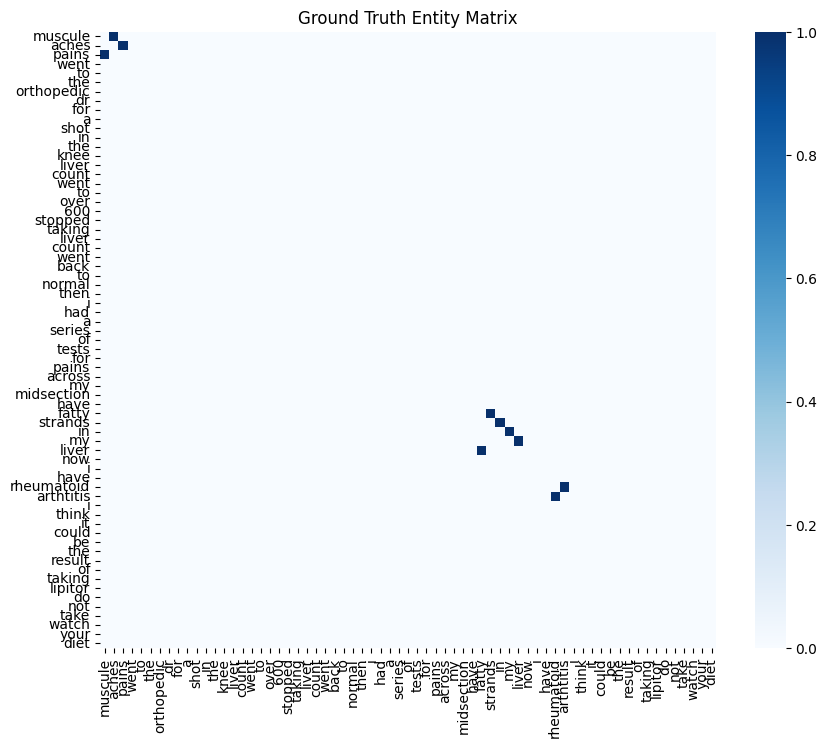

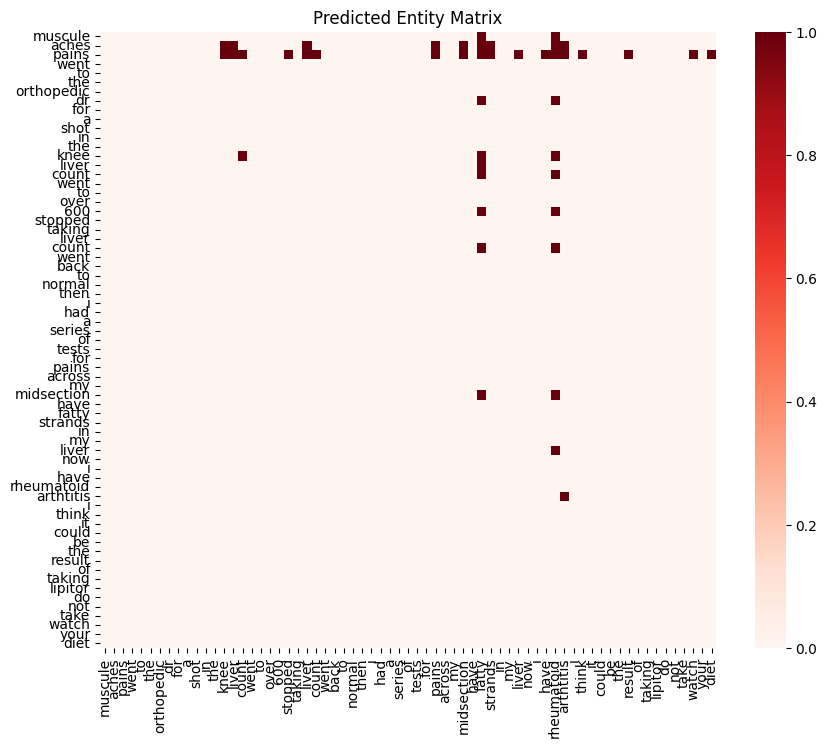

In [ ]:
import json
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import random
from transformers import AutoTokenizer

# Load trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EntityMatrixPredictor().to(device)
model.load_state_dict(torch.load(f"{model_path}_upper", map_location=device))
model.eval()

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased", use_fast=True)

# Load a random CADEC example
file_path = f"{dataset_dir}/train/sentence_{random.randint(0, 600)}.json"
with open(file_path, "r") as f:
    data = json.load(f)

# Extract words and entity matrix
words = data["words"]
entity_matrix = np.array(data["entity_matrix"]).reshape(len(words), len(words))
entities = data["entities"]

# Print for reference
print("Words:")
print(words)
print("\nEntities:")
print(entities)

# Derive word-level spans from entity strings
def find_entity_spans(words, entity_list):
    spans = []
    text = " ".join(words)
    for entity in entity_list:
        entity_words = entity.split()
        for i in range(len(words) - len(entity_words) + 1):
            if words[i:i+len(entity_words)] == entity_words:
                spans.append((i, i + len(entity_words) - 1))
                break  # only first match
    return spans

spans = find_entity_spans(words, entities)

# Highlight span words
def highlight_spans(words, spans):
    highlighted = words[:]
    for start, end in spans:
        for i in range(start, end + 1):
            highlighted[i] = f"[{words[i]}]"
    return highlighted

highlighted_words = highlight_spans(words, spans)
print("\nHighlighted Words:")
print(" ".join(highlighted_words))

# Tokenize input for the model
encoding = tokenizer(words, is_split_into_words=True, return_tensors="pt", padding=True, truncation=True)
input_ids = encoding["input_ids"].to(device)
attention_mask = encoding["attention_mask"].to(device)
word_ids = encoding.word_ids()

# Get prediction
with torch.no_grad():
    pred_matrix = model(input_ids=input_ids, attention_mask=attention_mask, word_ids=[word_ids]).squeeze(0).cpu().numpy()

# Binarize
pred_matrix_binary = (pred_matrix > 0.5).astype(int)

# Determine color scale
if np.all(pred_matrix_binary == 1) or np.all(pred_matrix_binary == 0):
    vmin, vmax = entity_matrix.min(), entity_matrix.max()
else:
    vmin, vmax = 0, 1

# Plotting function
def plot_heatmap(matrix, title, words, cmap, vmin, vmax):
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix[:len(words), :len(words)], annot=False, cbar=True, square=True, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.xticks(ticks=np.arange(len(words)) + 0.5, labels=words, rotation=90)
    plt.yticks(ticks=np.arange(len(words)) + 0.5, labels=words, rotation=0)
    plt.title(title)
    plt.show()

# Plot both matrices
plot_heatmap(entity_matrix, "Ground Truth Entity Matrix", words, cmap="Blues", vmin=0, vmax=1)
plot_heatmap(pred_matrix_binary, "Predicted Entity Matrix", words, cmap="Reds", vmin=vmin, vmax=vmax)


# Metrics

In [10]:
import torch
import time

# Define the pos_weight values to test
pos_weight_values = list(range(10,20))  # Modify as needed
num_runs_per_weight = 3

metrics_file = "./metrics/cadec.md"
best_f1 = 0
best_pos_weight = None

with open(metrics_file, "a") as f:  # Append mode
    f.write("\n---\n")
    f.write(f"### Experiment on {time.strftime('%Y-%m-%d %H:%M:%S')}\n")

for pos_weight in pos_weight_values:
    total_precision, total_recall, total_f1 = 0, 0, 0

    print(f"\nTesting pos_weight = {pos_weight}...")

    for _ in range(num_runs_per_weight):
        # Train the model
        trained_model = training_loop(pos_weight = pos_weight, epochs=3, verbose=False)
        torch.save(trained_model.state_dict(), f"{model_path}")
        
        # Evaluate the model
        precision, recall, f1 = evaluation_loop(model_path=model_path)  # Ensure evaluation_loop returns metrics

        total_precision += precision
        total_recall += recall
        total_f1 += f1

    # Compute averages
    avg_precision = total_precision / num_runs_per_weight
    avg_recall = total_recall / num_runs_per_weight
    avg_f1 = total_f1 / num_runs_per_weight

    print(f"pos_weight = {pos_weight} -> Precision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, F1: {avg_f1:.4f}")

    # Log results
    with open(metrics_file, "a") as f:
        f.write(f"\n#### pos_weight = {pos_weight}\n")
        f.write(f"- **Precision:** {avg_precision:.4f}\n")
        f.write(f"- **Recall:** {avg_recall:.4f}\n")
        f.write(f"- **F1 Score:** {avg_f1:.4f}\n")

    # Check if this is the best F1-score so far
    if avg_f1 > best_f1:
        best_f1 = avg_f1
        best_pos_weight = pos_weight

# Log the best pos_weight found
with open(metrics_file, "a") as f:
    f.write("\n### Best Hyperparameter:\n")
    f.write(f"- **Best pos_weight:** {best_pos_weight}\n")
    f.write(f"- **Best F1 Score:** {best_f1:.4f}\n")

print(f"\n✅ Best pos_weight found: {best_pos_weight} with F1 Score: {best_f1:.4f}")



Testing pos_weight = 10...


KeyboardInterrupt: 